In [15]:
import socket
import time
import codecs
import io
import os
import json
import cv2
import base64
from PIL import Image
import sys
import traceback as tb

## -----Creating socket and getting information about it
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
local_hostname = socket.gethostname() 
local_fqdn = socket.getfqdn() ##---get fully qualified hostname

## -----Connection to server
ip_adress = socket.gethostbyname(local_hostname) 
server_adress = (ip_adress, 23458) ##---Bind the socket to the port and connect
sock.connect(server_adress)
print ("connecting to %s (%s) with %s" % (local_hostname, local_fqdn, ip_adress))

id = 1 ##---Request number
filename = input("enter filename: ")

try:
    ### -----Reading image
    if os.path.exists('yolov5/test/images/%s.jpg' % filename):
        file = codecs.open('yolov5/test/images/%s.jpg' % filename, "rb")
        request = {"id":id, "data":b''} ##---Request on server

        ### -----Writing image to request
        while True:
            file_data = file.read(2**18) 
            request["data"] += file_data  
            if not file_data:
                break

        ### -----Sending request in json
        b64string = base64.b64encode(request["data"]) 
        request["data"] = b64string.decode() ### ---Bytes to string
        sock.send(json.dumps(request).encode()) 

        ### -----Getting response from server
        answer = sock.recv(2**18) ##---Response in bytes
        answer_json = answer.decode() ##---Bytes to json
        result = json.loads(answer_json) 
        print(result)

        ### -----Printing result
#         if result["data"]:
#             print('res is: ' + str(result["data"]))    
        time.sleep(2)
        print('FINISH')
        id = id+1
    else:
        print('no such file, error')
    
### -----Exception    
except Exception as e:
    if os.path.exists('yolov5/test/images/%s.jpg' % filename) == False:
        print('no such file')
    exception_type, exception_object, exception_traceback = sys.exc_info()
    filename = exception_traceback.tb_frame.f_code.co_filename
    line_number = exception_traceback.tb_lineno
    print("Exception type: ", exception_type)
    print("File name: ", filename)
    print("Line number: ", line_number)
    raise e
    
finally:
    sock.close()
    print('bye')


connecting to user-desktop (user-desktop) with 127.0.1.1
enter filename: 3
{'id': 1, 'data': [{'text': 'P887/7-1b', 'bbox': [50, 168, 255, 87], 'conf': 0.9196330308914185}], 'success': True}
FINISH
bye


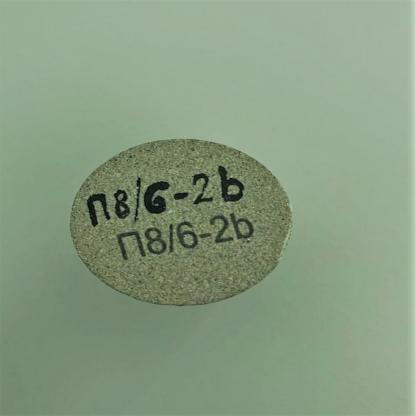

In [10]:
import cv2, random
import numpy as np
from io import BytesIO
import PIL.Image
import IPython.display

def array_to_image(a, fmt='jpeg'):
    f = BytesIO()    
    PIL.Image.fromarray(a).save(f, fmt)    
    return IPython.display.Image(data=f.getvalue())

def plot_one_box_xywh(x, img, color=None, label=None, line_thickness=3):
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
#     c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    c1, c2 = (x[0],x[1]), (x[0]+x[2],x[1]+x[3]),
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return img

img = PIL.Image.open( BytesIO(base64.b64decode(request["data"])))
img = np.array(img)

for data in result['data']:
    img = plot_one_box_xywh(
        data['bbox'], 
        img,
        label='Text %s [%.2f]' % (data['conf'], data['text']), 
        line_thickness=2)
array_to_image(img)
